# Pharmaceutical LLM RAG

##### In this notebook we are testing the following models to analyze the performance of answering different pharmaceutical question:
 - Asi mini
 - Llama 3(locally)
 - ChatGPT 3.5

For each model a langchain is built to give the models context of different drugs but we are also testing the models without RAG to analyse the performance.

For testing **Giskard** is used to generate from pdfs questions and answers which are going to be compared against the output of the models mentioned above. Giskard used GPT 3.5 to analyse Asi mini and Llama 3, and GPT 4 to analyse GPT 3.5

Afterwards query translations are used for one of the models(Asi mini) to see how it enhances the performance of the given tasks. The following querry translations methods are used:
- Multi query
- RAG-Fusion
- Decomposition
- Step Back
- HyDE

##### Imports & Variables

In [1]:
import os
import requests
import pandas as pd

from operator import itemgetter
from pathlib import Path

from langchain_openai import OpenAIEmbeddings
from langchain_openai.chat_models import ChatOpenAI
from langchain_ollama import OllamaLLM 
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain.prompts import ChatPromptTemplate
from langchain.load import dumps, loads
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import FewShotChatMessagePromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser

import giskard
from giskard.rag import KnowledgeBase
from giskard.rag import generate_testset
from giskard.rag import evaluate
from giskard.rag import QATestset
from giskard.rag.question_generators import ComplexQuestionsGenerator

from dotenv import load_dotenv
load_dotenv()

ASI_ONE_KEY = os.getenv("ASI_ONE_KEY")

In [2]:
PDF_PATH = "pdf_10"
VECTORSTORE_PATH = "./chroma_db_100"
TESTSET_PATH = "test-set-100.jsonl"

MODEL = "asi1-mini"
MODEL_LLAMA3 = "llama3"
MODEL_CHATGPT_3_5 = "gpt-3.5-turbo"

SEARCH_KWARGS = 3
NUM_QUESTIONS = 25

### Pre-processing ###

In [3]:
full_documents = []

pdf_folder = Path(PDF_PATH)
pdf_files = list(pdf_folder.glob("*.pdf"))

for filepath in pdf_files:
    try:
        loader = PyPDFLoader(filepath)
        docs = loader.load()
        full_documents.extend(docs)
        print(f"Parsed {filepath} with {len(docs)} chunks.")
    except Exception as e:
        print(f"Error parsing {filepath}: {e}")

Parsed pdf_10/doc_57.pdf with 2 chunks.
Parsed pdf_10/doc_85.pdf with 25 chunks.
Parsed pdf_10/doc_8.pdf with 3 chunks.
Parsed pdf_10/doc_98.pdf with 27 chunks.
Parsed pdf_10/doc_15.pdf with 5 chunks.
Parsed pdf_10/doc_97.pdf with 18 chunks.
Parsed pdf_10/doc_7.pdf with 6 chunks.
Parsed pdf_10/doc_3.pdf with 3 chunks.
Parsed pdf_10/doc_86.pdf with 25 chunks.
Parsed pdf_10/doc_28.pdf with 5 chunks.


In [4]:
len(full_documents)

119

In [5]:
full_documents[0].page_content

'ADEA GARGLE- citric acid, sodium hydrogen carbonate, xylitol tablet, chewable \n \nK2resource co., ltd.\nDisclaimer: This drug has not been found by FDA to be safe and effective, and this labeling has not been\napproved by FDA. \nFor further information about unapproved drugs, click here.\n----------\nCITRIC ACID, SODIUM HYDROGEN CARBONATE, XYLITOL\nFor oral care: Tooth whitening, removing bad breath, preventing tooth decay, preventing gingivitis and\ntartar formation, plaque removal, oral cleansing\nKeep out of reach of children\nPut a tablet of Adea Gargle in your mouth and chew or melt according to your preference.\nWhen foaming starts, please gaggle for more than 30 seconds so that every corner of the mouth can\nreach Adea Gaggle.\nWhen the gaggle is over, spit or swallow the bubbles.\nAirtight container\nStorage at room temperature\nPlease close the lid tightly after opening.\nAvoid direct sunlight and store in a cool place.\nFor specific or unusual constitution, allergic constit

### Split

In [6]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

splits = text_splitter.split_documents(full_documents)

In [7]:
len(splits)

314

### Index with Retrieval

In [8]:
### Create vectorstore only if needed
create = False

if create:
    print("Creating vectorstore")
    vectorstore = Chroma.from_documents(documents=splits, 
                                        embedding=OpenAIEmbeddings(model="text-embedding-3-small"),
                                        persist_directory=VECTORSTORE_PATH
    )
    vectorstore.persist()
else:
    print("Using existing vector store")
    embedding_function = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = Chroma(
        persist_directory=VECTORSTORE_PATH,
        embedding_function=embedding_function
    )

Using existing vector store


/tmp/ipykernel_9434/2185640746.py:14: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [9]:
retriever = vectorstore.as_retriever(search_kwargs={"k": SEARCH_KWARGS})

### Models

In [10]:
template = """
    Answer the given question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [11]:
template_rag = """
Answer the question only based on the context below use only the given knowledge from the context do not invent or add details that you were treained. 
If you dont know the answer say that you dont know.

Context: {context}

Question: {question}
"""
prompt_rag = ChatPromptTemplate.from_template(template_rag)

#### Asi One Mini RAG

In [12]:
def call_asi_one(prompt):
    if hasattr(prompt, "to_string"):
        prompt = prompt.to_string()

    url = "https://api.asi1.ai/v1/chat/completions"
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {ASI_ONE_KEY}'
    }
    payload = {
        "model": MODEL,
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.2,
        "max_tokens": 1000
    }
    response = requests.post(url, headers=headers, json=payload)
    return response.json().get("choices", [{}])[0].get("message", {}).get("content", "No response")

In [13]:
chain_asi_rag = ({
    "context": itemgetter("question") | vectorstore.as_retriever(),
    "question": itemgetter("question"),
}
| prompt_rag
| call_asi_one
| StrOutputParser()
)

#### Asi One Mini


In [33]:
chain_asi = ({
    "question": itemgetter("question"),
}
| prompt
| call_asi_one
| StrOutputParser()
)

#### Llama 3 RAG


In [72]:
model_llama = OllamaLLM(model=MODEL_LLAMA3)

chain_llama3_rag = (
    {
        "context": itemgetter("question") | vectorstore.as_retriever(),
        "question": itemgetter("question"),
    }
    | prompt_rag
    | model_llama
    | StrOutputParser()
)

#### LLama 3

In [73]:
chain_llama3 = ({
    "question": itemgetter("question"),
}
| prompt
| model_llama
| StrOutputParser()
)

#### Gpt 3.5 RAG

In [31]:
model_gpt_3_5 = ChatOpenAI(model=MODEL_CHATGPT_3_5)

chain_gpt_3_5_rag = (
    {
        "context": itemgetter("question") | vectorstore.as_retriever(),
        "question": itemgetter("question"),
    }
    | prompt_rag
    | model_gpt_3_5
    | StrOutputParser()
)

#### Gpt 3.5

In [48]:
chain_gpt_3_5 = ({
    "question": itemgetter("question"),
}
| prompt
| model_gpt_3_5
| StrOutputParser()
)

### Testing models (Giskard)

#### Preparint testsets

In [14]:
giskard.llm.set_llm_model("gpt-3.5-turbo")
giskard.llm.set_embedding_model("text-embedding-3-small")

In [15]:
len(full_documents)

119

In [16]:
df = pd.DataFrame([d.page_content for d in full_documents], columns=["text"])
knowledge_base = KnowledgeBase(df)

In [17]:
generate_tests = False

if generate_tests:
    print("Create new test set")
    testset = generate_testset(
        knowledge_base=knowledge_base,
        num_questions=NUM_QUESTIONS,
        question_generators = ComplexQuestionsGenerator(),
        agent_description="A chatbot answering questions about medicine drugs based on a given context",
    )

    testset.save("test-set-10.jsonl")
else:
    print("Using existing test set")
    testset = QATestset.load("test-set-10.jsonl")

Using existing test set


In [44]:
generate_tests_gpt_4 = False

if generate_tests_gpt_4:
    print("Create new test set")
    giskard.llm.set_llm_model("gpt-4o")
    testset_gpt4o = generate_testset(
        knowledge_base=knowledge_base,
        num_questions=NUM_QUESTIONS,
        question_generators = ComplexQuestionsGenerator(),
        agent_description="A chatbot answering questions about medicine drugs based on a given context",
    )

    testset_gpt4o.save("test-set-gpt-4o-10.jsonl")
else:
    print("Using existing test set")
    testset_gpt4o = QATestset.load("test-set-gpt-4o-10.jsonl")

Create new test set
2025-06-22 09:43:48,897 pid:11544 MainThread giskard.rag  INFO     Finding topics in the knowledge base.


/home/deni/Desktop/disi/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2025-06-22 09:43:54,202 pid:11544 MainThread giskard.rag  INFO     Found 3 topics in the knowledge base.


Generating questions:   0%|          | 0/25 [00:00<?, ?it/s]

#### Asi mini RAG

In [117]:
def answer_fn_asi_rag(question, history=None):
    return chain_asi_rag.invoke({"question": question})

In [170]:
report = evaluate(answer_fn_asi_rag, testset=testset)
display(report)

Asking questions to the agent:   0%|          | 0/25 [00:00<?, ?it/s]

CorrectnessMetric evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

Loading BokehJS ...

In [153]:

report.to_html(f"report-asi-mini_1.html")
dfc = pd.DataFrame(report.component_scores())
dfc.to_csv(f"component_scores_1.csv", index=False)
dfr = report.to_pandas()
dfr.to_excel(f"all_results_1.xlsx", index=False)

In [23]:
failures = report.get_failures()
failures

,question,reference_answer,reference_context,conversation_history,metadata,agent_answer,correctness,correctness_reason
id,,,,,,,,
dd9a3fcd-acd0-494f-863e-82c591f95d44,How does nitisinone benefit patients with HT-1...,"In patients with HT-1, nitisinone prevents the...",Document 8: Nitisinone is a competitive inhibi...,[],"{'question_type': 'complex', 'seed_document_id...",Nitisinone benefits patients with HT-1 by comp...,False,The agent provided a detailed explanation of h...


In [84]:
failures.iloc[40].agent_answer

'No response'

In [36]:
report.correctness_by_question_type()

,correctness
question_type,
complex,0.318182


#### Asi Mini

In [38]:
def answer_fn_asi(question, history=None):
    return chain_asi.invoke({"question": question})

In [39]:
report = evaluate(answer_fn_asi, testset=testset, knowledge_base=knowledge_base)
display(report)

Asking questions to the agent:   0%|          | 0/25 [00:00<?, ?it/s]

CorrectnessMetric evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

Loading BokehJS ...

2025-06-22 08:54:41,938 pid:8644 MainThread giskard.rag  INFO     Finding topics in the knowledge base.


/home/deni/Desktop/disi/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2025-06-22 08:54:49,702 pid:8644 MainThread giskard.rag  INFO     Found 6 topics in the knowledge base.


In [40]:
report.to_html(f"report-asi-mini_10.html")
dfc = pd.DataFrame(report.component_scores())
dfc.to_csv(f"component_scores_10.csv", index=False)
dfr = report.to_pandas()
dfr.to_excel(f"all_results_10.xlsx", index=False)

In [121]:
report.get_failures()

,question,reference_answer,reference_context,conversation_history,metadata,agent_answer,correctness,correctness_reason
id,,,,,,,,
8fc13a32-5c34-4809-be6e-411fb6fdc659,What are the specific inactive ingredients pre...,The inactive ingredients in the 100 mg Metopro...,Document 19: Product Information\nProduct Type...,[],"{'question_type': 'complex', 'seed_document_id...",The 100 mg **Metoprolol Tartrate** tablet typi...,False,The agent provided additional inactive ingredi...
64868d56-c2ee-4a73-b878-bb4e177a3574,What are the strengths available for the drug ...,The strengths available for the drug LOPRESSOR...,Document 18: Product Type\nHUMAN PRESCRIPTION ...,[],"{'question_type': 'complex', 'seed_document_id...",Great question! Let me break down the availabl...,False,The agent provided additional information abou...
aa6813b1-64a3-4bfe-b8ec-e06dae6eb46c,What adverse reactions related to the cardiova...,"Shortness of breath, bradycardia, cold extremi...",Document 6: 5.\n9\n \n \nPeripheral Vascular ...,[],"{'question_type': 'complex', 'seed_document_id...",Here’s a detailed breakdown of cardiovascular ...,False,The agent provided a detailed breakdown of car...
ca0d8cf3-c32c-4a73-8d25-10c7d05e5ef2,What is the specific indication of LOPRESSOR i...,LOPRESSOR is indicated for the treatment of hy...,Document 2: 8.6 \n \nHepatic Impairment\n8.7 ...,[],"{'question_type': 'complex', 'seed_document_id...",LOPRESSOR (metoprolol tartrate) is a beta-adre...,False,The agent provided detailed information about ...
3e408a82-a894-419c-8aa5-f1b1dbf49565,"In patients with hepatic impairment, what is t...",LOPRESSOR therapy should be considered to be i...,Document 1: CYP2D6 Inhibitors are likely to in...,[],"{'question_type': 'complex', 'seed_document_id...",For patients with hepatic impairment initiatin...,False,The agent provided detailed dosage adjustment ...
65310709-e66e-4559-8d7a-fcd02bff44aa,In which year did LOPRESSOR (metoprolol tartra...,LOPRESSOR (metoprolol tartrate) tablets receiv...,Document 0: LOPRESSOR- metoprolol tartrate tab...,[],"{'question_type': 'complex', 'seed_document_id...","Metoprolol tartrate, marketed under the brand ...",False,The agent stated that LOPRESSOR received its i...
3a204c07-3317-4cdc-b8f9-b30c8241f0d3,Under what circumstance should patients with b...,Patients with bronchospastic disease should ge...,Document 5: dose of LOPRESSOR \n[see \nDosage ...,[],"{'question_type': 'complex', 'seed_document_id...",**Answer:** \n\nPatients with **bronchospasti...,False,The agent provided detailed information about ...
a88b55b7-4dcc-4d5a-9971-368fe0b8e344,What are the different strengths of Lopressor ...,Lopressor tablets are available in two strengt...,Document 17: NDC 30698-458-01\nLopressor\n(met...,[],"{'question_type': 'complex', 'seed_document_id...",Lopressor (generic name: metoprolol tartrate) ...,False,The agent provided information on three streng...
4703bc81-6477-4795-bc48-e213b273ffed,What are some of the adverse reactions that ha...,Some adverse reactions reported during post ap...,Document 7: Lopressor\nPlacebo\nHypotension (s...,[],"{'question_type': 'complex', 'seed_document_id...",Here are the reported adverse reactions during...,False,The agent provided a detailed list of adverse ...


#### Llama 3 RAG

In [69]:
def answer_fn_llama3_rag(question, history=None):
    return chain_llama3_rag.invoke({"question": question})

In [70]:
report = evaluate(answer_fn_llama3_rag, testset=testset, knowledge_base=knowledge_base)
display(report)

Asking questions to the agent:   0%|          | 0/2 [00:00<?, ?it/s]

CorrectnessMetric evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

Loading BokehJS ...

#### Llama 3

In [74]:
def answer_fn_llama3(question, history=None):
    return chain_llama3.invoke({"question": question})

In [75]:
report = evaluate(answer_fn_llama3, testset=testset, knowledge_base=knowledge_base)
display(report)

Asking questions to the agent:   0%|          | 0/2 [00:00<?, ?it/s]

CorrectnessMetric evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

Loading BokehJS ...

#### Gpt 3.5 RAG

In [45]:
def answer_fn_chain_gpt_3_5_rag(question, history=None):
    return chain_gpt_3_5_rag.invoke({"question": question})

In [46]:
report = evaluate(answer_fn_chain_gpt_3_5_rag, testset=testset_gpt4o, knowledge_base=knowledge_base)
display(report)

Asking questions to the agent:   0%|          | 0/25 [00:00<?, ?it/s]

CorrectnessMetric evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

Loading BokehJS ...

In [47]:
#report.to_html("report-gpt-3-5-rag-100.html")

report.to_html(f"report-gpt-3-5-rag_10.html")
dfc = pd.DataFrame(report.component_scores())
dfc.to_csv(f"component_scores_10.csv", index=False)
dfr = report.to_pandas()
dfr.to_excel(f"all_results_10.xlsx", index=False)

#### Gpt 3.5

In [49]:
def answer_fn_chain_gpt_3_5(question, history=None):
    return chain_gpt_3_5.invoke({"question": question})

In [50]:
report = evaluate(answer_fn_chain_gpt_3_5, testset=testset_gpt4o, knowledge_base=knowledge_base)
display(report)

Asking questions to the agent:   0%|          | 0/25 [00:00<?, ?it/s]

CorrectnessMetric evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

Loading BokehJS ...

In [51]:
#report.to_html("report-gpt-3-5-100.html")
report.to_html(f"report-gpt-3-5_10.html")
dfc = pd.DataFrame(report.component_scores())
dfc.to_csv(f"component_scores_10.csv", index=False)
dfr = report.to_pandas()
dfr.to_excel(f"all_results_10.xlsx", index=False)

## Asi Mini with query translations

#### Multi query

In [14]:
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}
"""

prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives 
    | call_asi_one 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

def get_unique_union(documents: list[list]):
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    unique_docs = list(set(flattened_docs))
    return [loads(doc) for doc in unique_docs]

retrieval_chain = generate_queries | retriever.map() | get_unique_union

chain_multiquery = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt_rag
    | call_asi_one
    | StrOutputParser()
)

In [15]:
def answer_fn_chain_multiquery(question, history=None):
    return chain_multiquery.invoke({"question": question})

In [20]:
report = evaluate(answer_fn_chain_multiquery, testset=testset, knowledge_base=knowledge_base)
display(report)

Asking questions to the agent:   0%|          | 0/25 [00:00<?, ?it/s]

/tmp/ipykernel_11544/3778061180.py:20: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  return [loads(doc) for doc in unique_docs]


CorrectnessMetric evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

Loading BokehJS ...

2025-06-22 08:58:22,538 pid:11544 MainThread giskard.rag  INFO     Finding topics in the knowledge base.


/home/deni/Desktop/disi/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2025-06-22 08:58:38,581 pid:11544 MainThread giskard.rag  INFO     Found 6 topics in the knowledge base.


#### RAG-Fusion

In [95]:
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_rag_fusion 
    | call_asi_one
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

def reciprocal_rank_fusion(results: list[list], k=60):
    fused_scores = {}

    for docs in results:
        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            previous_score = fused_scores[doc_str]
            fused_scores[doc_str] += 1 / (rank + k)

    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion

chain_rag_fusion = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt_rag
    | call_asi_one
    | StrOutputParser()
)

In [96]:
def answer_fn_chain_rag_fusion(question, history=None):
    return chain_rag_fusion.invoke({"question": question})

In [97]:
report = evaluate(answer_fn_chain_rag_fusion, testset=testset, knowledge_base=knowledge_base)
display(report)

Asking questions to the agent:   0%|          | 0/2 [00:00<?, ?it/s]

CorrectnessMetric evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

Loading BokehJS ...

#### Decomposition

In [18]:
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

def format_qa_pair(question, answer):
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

generate_queries_decomposition = (
    prompt_decomposition 
    | call_asi_one 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

def answer_fn_chain_decomposition(question, history=None):
    questions = generate_queries_decomposition.invoke({"question": question})
    
    q_a_pairs = ""
    
    for q in questions:
        rag_chain = (
            {
                "context": itemgetter("question") | retriever,
                "question": itemgetter("question"),
                "q_a_pairs": itemgetter("q_a_pairs")
            }
            | decomposition_prompt
            | call_asi_one
            | StrOutputParser()
        )
        
        answer = rag_chain.invoke({"question": q, "q_a_pairs": q_a_pairs})
        q_a_pair = format_qa_pair(q, answer)
        q_a_pairs = q_a_pairs + "\n---\n" + q_a_pair
    
    chain_decomposition = (
        {
            "context": itemgetter("question") | retriever,
            "question": itemgetter("question"),
            "q_a_pairs": itemgetter("q_a_pairs")
        }
        | decomposition_prompt
        | call_asi_one
        | StrOutputParser()
    )
    
    return chain_decomposition.invoke({"question": question, "q_a_pairs": q_a_pairs})

In [19]:
report = evaluate(answer_fn_chain_decomposition, testset=testset, knowledge_base=knowledge_base)
display(report)

Asking questions to the agent:   0%|          | 0/25 [00:00<?, ?it/s]

CorrectnessMetric evaluation:   0%|          | 0/25 [00:00<?, ?it/s]

Loading BokehJS ...

2025-06-23 09:37:54,138 pid:9434 MainThread giskard.rag  INFO     Finding topics in the knowledge base.


/home/deni/Desktop/disi/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2025-06-23 09:38:14,378 pid:9434 MainThread giskard.rag  INFO     Found 6 topics in the knowledge base.


#### Step Back

In [107]:
examples = [
    {
        "input": "Can I take ibuprofen if I’m pregnant?",
        "output": "What are the risks of taking ibuprofen during pregnancy?",
    },
    {
        "input": "Will Paracetamol interact with my blood pressure medication?",
        "output": "What drug interactions involve Paracetamol?",
    }]

example_prompt = ChatPromptTemplate.from_messages([
    ("human", "{input}"),
    ("ai", "{output}"),
])
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

step_back_template = ChatPromptTemplate.from_messages([
    ("system", "You are an expert in medicine drugs. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:"),
    few_shot_prompt,
    ("user", "{question}"),
])
generate_queries_step_back = step_back_template | call_asi_one | StrOutputParser()

response_prompt_template = """You are an expert in medicine drugs. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

def answer_fn_chain_step_back(question):
    chain_step_back = (
        {
            "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
            "step_back_context": generate_queries_step_back | retriever,
            "question": lambda x: x["question"],
        }
        | response_prompt
        | call_asi_one
        | StrOutputParser()
    )
    return chain_step_back.invoke({"question": question})

In [108]:
report = evaluate(answer_fn_chain_step_back, testset=testset, knowledge_base=knowledge_base)
display(report)

Asking questions to the agent:   0%|          | 0/2 [00:00<?, ?it/s]

CorrectnessMetric evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

Loading BokehJS ...

#### HyDE

In [111]:
hyde_template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(hyde_template)

generate_docs_for_retrieval = (
    prompt_hyde | call_asi_one | StrOutputParser()
)

chain_hyde = (
    prompt_rag
    | call_asi_one
    | StrOutputParser()
)

def answer_fn_chain_hyde(question):
    pseudo_doc = generate_docs_for_retrieval.invoke({"question": question})
    
    retrieved_docs = retriever.invoke(pseudo_doc)
    
    return chain_hyde.invoke({
        "context": retrieved_docs,
        "question": question
    })

In [112]:
report = evaluate(answer_fn_chain_hyde, testset=testset, knowledge_base=knowledge_base)
display(report)

Asking questions to the agent:   0%|          | 0/2 [00:00<?, ?it/s]

CorrectnessMetric evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

Loading BokehJS ...

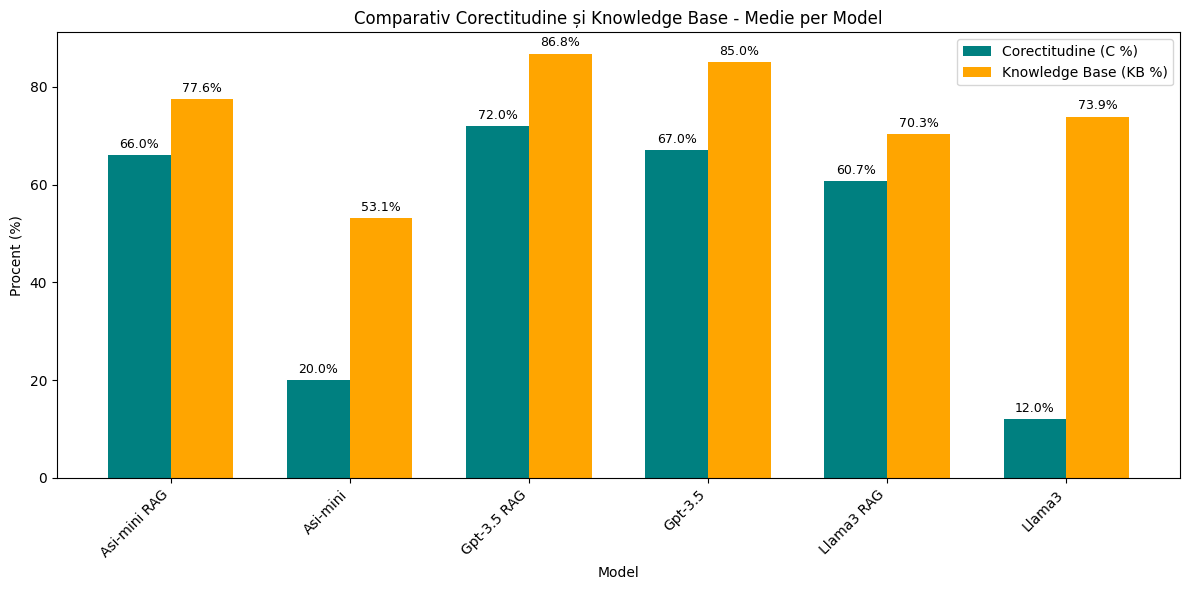

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparative_c_kb():
    # Modele
    models = [
        "Asi-mini RAG", "Asi-mini",
        "Gpt-3.5 RAG", "Gpt-3.5",
        "Llama3 RAG", "Llama3"
    ]

    # Valorile medii
    c_values = [66.00, 20.00, 72.00, 67.00, 60.67, 12.00]
    kb_values = [77.56, 53.13, 86.82, 85.04, 70.31, 73.93]

    # Setări pentru poziționarea barelor
    x = np.arange(len(models))
    width = 0.35  # lățimea fiecărei bare

    # Creare grafic
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, c_values, width, label='Corectitudine (C %)', color='teal')
    bars2 = ax.bar(x + width/2, kb_values, width, label='Knowledge Base (KB %)', color='orange')

    # Etichete peste fiecare bară
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    # Etichete și format
    ax.set_ylabel('Procent (%)')
    ax.set_xlabel('Model')
    ax.set_title('Comparativ Corectitudine și Knowledge Base - Medie per Model')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Apelează funcția
plot_comparative_c_kb()


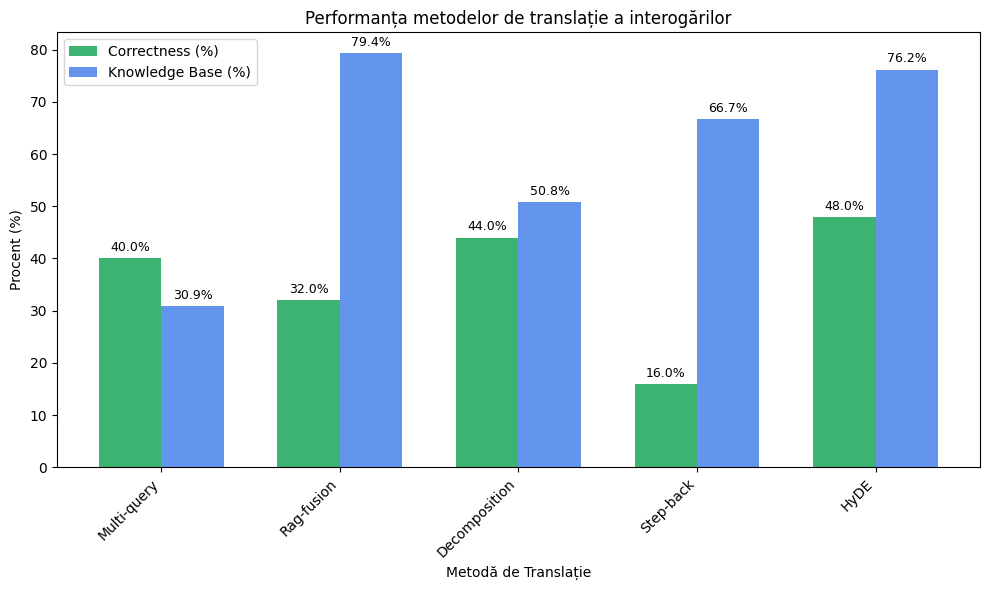

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_translation_methods():
    # Metodele și scorurile
    methods = ["Multi-query", "Rag-fusion", "Decomposition", "Step-back", "HyDE"]
    correctness = [40.00, 32.00, 44.00, 16.00, 48.00]
    kb = [30.95, 79.36, 50.79, 66.66, 76.19]

    x = np.arange(len(methods))
    width = 0.35

    # Grafic
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, correctness, width, label='Correctness (%)', color='mediumseagreen')
    bars2 = ax.bar(x + width/2, kb, width, label='Knowledge Base (%)', color='cornflowerblue')

    # Etichete
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    # Titluri și stil
    ax.set_ylabel('Procent (%)')
    ax.set_xlabel('Metodă de Translație')
    ax.set_title('Performanța metodelor de translație a interogărilor')
    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Apelează funcția
plot_translation_methods()
